In [79]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme


In [88]:
set_nb_theme('onedork')


                                           
# <font color='green'>Stock Market Prediction using Numerical and Textual Analysis¶</font>

 #                     <font color='blue'>BATHULA SAI CHARAN</font>                                        

## Task of this project is about predicting the stocks based on past stock details and news
### we do numerical analysis and textual analyisis using NLP to get good accuracy of our predictions
-  Download stock data from https://finance.yahoo.com/
- Download text data from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DPQMQH

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools


from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA


import nltk
import re
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('vader_lexicon')


from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm

In [2]:
stock_price = pd.read_csv('GC=F.csv',date_parser = True)
stock_headlines = pd.read_csv('india-news-headlines.csv')
stock_price

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,268.399994,268.399994,268.399994,268.399994,268.399994,0.0
1,2001-01-03,268.000000,268.000000,268.000000,268.000000,268.000000,1.0
2,2001-01-04,267.299988,267.299988,267.299988,267.299988,267.299988,1.0
3,2001-01-05,268.000000,268.000000,268.000000,268.000000,268.000000,0.0
4,2001-01-08,268.000000,268.000000,268.000000,268.000000,268.000000,0.0
...,...,...,...,...,...,...,...
5216,2021-06-30,1761.099976,1770.800049,1759.199951,1770.800049,1770.800049,51.0
5217,2021-07-01,1775.699951,1781.199951,1768.800049,1775.900024,1775.900024,44.0
5218,2021-07-02,1778.699951,1787.900024,1778.300049,1782.599976,1782.599976,23.0
5219,2021-07-06,1786.699951,1809.800049,1786.699951,1793.500000,1793.500000,23.0


In [4]:
stock_headlines

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
...,...,...,...
3424062,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,removed,Govt extends deadline for use of FASTag till F...


# Data preprocessing

In [3]:
stock_price.shape

(5221, 7)

In [4]:
stock_headlines.shape

(3424067, 3)

### remove nulls and duplicates

In [5]:
stock_price.isnull().sum()

Date           0
Open         107
High         107
Low          107
Close        107
Adj Close    107
Volume       107
dtype: int64

In [6]:
stock_headlines.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [7]:
stock_price.dropna(inplace = True)
stock_price = stock_price.drop_duplicates()
stock_headlines.dropna(inplace = True)
stock_headlines = stock_headlines.drop_duplicates()

In [8]:
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5114 entries, 0 to 5220
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5114 non-null   object 
 1   Open       5114 non-null   float64
 2   High       5114 non-null   float64
 3   Low        5114 non-null   float64
 4   Close      5114 non-null   float64
 5   Adj Close  5114 non-null   float64
 6   Volume     5114 non-null   float64
dtypes: float64(6), object(1)
memory usage: 319.6+ KB


In [9]:
## date is npt recognised as it was string,so use to_datetime and setting it as index
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()
stock_price.set_index('Date', inplace= True)

In [10]:
stock_price

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,268.399994,268.399994,268.399994,268.399994,268.399994,0.0
2001-01-03,268.000000,268.000000,268.000000,268.000000,268.000000,1.0
2001-01-04,267.299988,267.299988,267.299988,267.299988,267.299988,1.0
2001-01-05,268.000000,268.000000,268.000000,268.000000,268.000000,0.0
2001-01-08,268.000000,268.000000,268.000000,268.000000,268.000000,0.0
...,...,...,...,...,...,...
2021-06-30,1761.099976,1770.800049,1759.199951,1770.800049,1770.800049,51.0
2021-07-01,1775.699951,1781.199951,1768.800049,1775.900024,1775.900024,44.0
2021-07-02,1778.699951,1787.900024,1778.300049,1782.599976,1782.599976,23.0


In [11]:
#now
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5114 entries, 2001-01-02 to 2021-07-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5114 non-null   float64
 1   High       5114 non-null   float64
 2   Low        5114 non-null   float64
 3   Close      5114 non-null   float64
 4   Adj Close  5114 non-null   float64
 5   Volume     5114 non-null   float64
dtypes: float64(6)
memory usage: 279.7 KB


# Using numerical analysis of historical stock prices

Text(0, 0.5, 'Close')

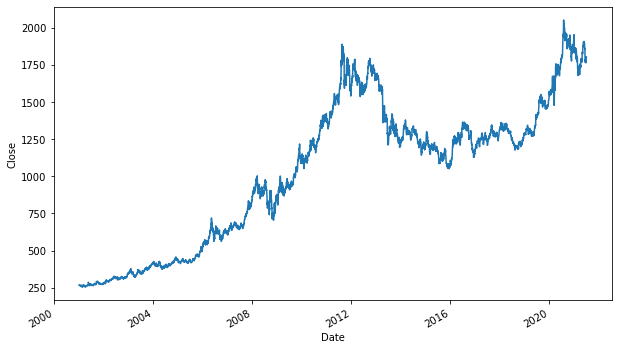

In [12]:
plt.figure(figsize=(10, 6))
stock_price['Close'].plot()
plt.ylabel('Close')

In [13]:
stock_price.shape

(5114, 6)

seems like no stationarity, let's check with Adfuller test

In [14]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(16,8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries[:], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")
    

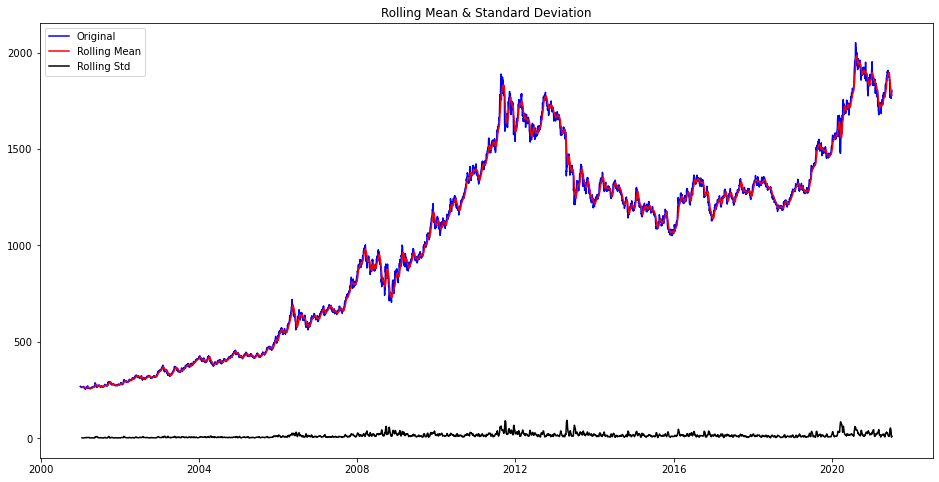

Results of Dickey Fuller Test:
Test Statistic                   -0.862505
p-value                           0.800069
#Lags Used                       11.000000
Number of Observations Used    5102.000000
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


In [15]:
close = stock_price['Close']
test_stationarity(close)

In [16]:
train = stock_price[:int(5144*0.85)]
test = stock_price[int(5144*0.85):]

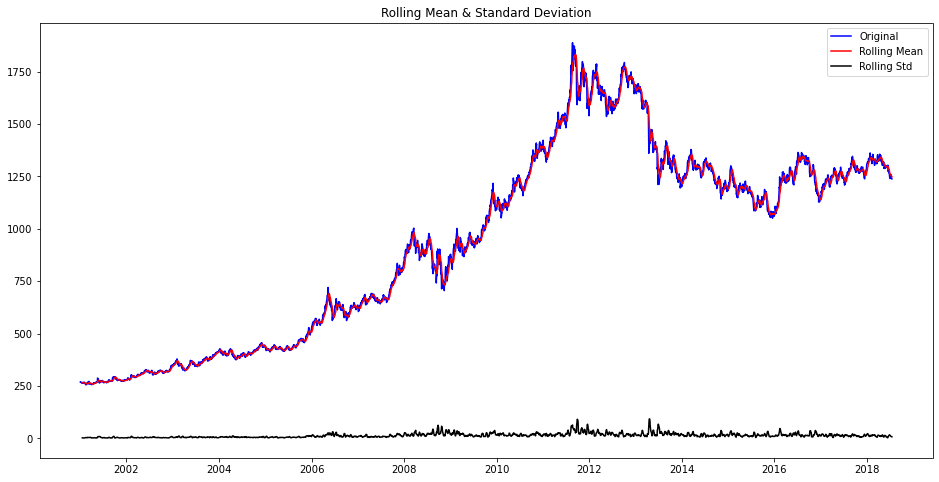

Results of Dickey Fuller Test:
Test Statistic                   -1.362600
p-value                           0.600069
#Lags Used                       11.000000
Number of Observations Used    4360.000000
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


In [17]:
test_stationarity(train['Close'])

### Apply transformation to data as data is not stationary

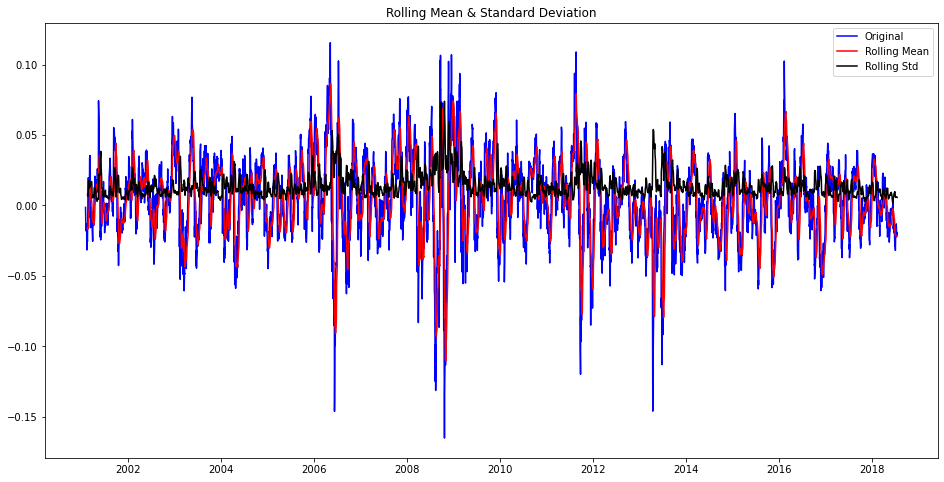

Results of Dickey Fuller Test:
Test Statistic                -1.151932e+01
p-value                        4.076445e-21
#Lags Used                     2.300000e+01
Number of Observations Used    4.325000e+03
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [18]:
train_log = np.log(train['Close']) # we did logarithmic transformation
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 

train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

# prediction stock 

In [19]:
datasetLogDiffShifting = pd.DataFrame(train_log_diff)

In [20]:
datasetLogDiffShifting

,Close
Date,
2001-02-05,-0.001357
2001-02-06,-0.007748
2001-02-07,-0.008832
2001-02-08,-0.018022
2001-02-09,-0.017512
...,...
2018-07-10,-0.015205
2018-07-11,-0.022222
2018-07-12,-0.018745


# Auto ARIMA

In [21]:
!pip install pmdarima

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\charan varma\\anaconda3\\Lib\\site-packages\\numpy\\~-ibs\\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



  Using cached numpy-1.19.5-cp38-cp38-win_amd64.whl (13.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0


In [22]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log_diff, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log_diff)
predictions = model.predict(n_periods = len(test_log))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-26720.004, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26728.005, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26726.034, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26726.035, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26730.004, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26723.792, Time=0.49 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.684 seconds


Text(0, 0.5, 'Actual Stock Price')

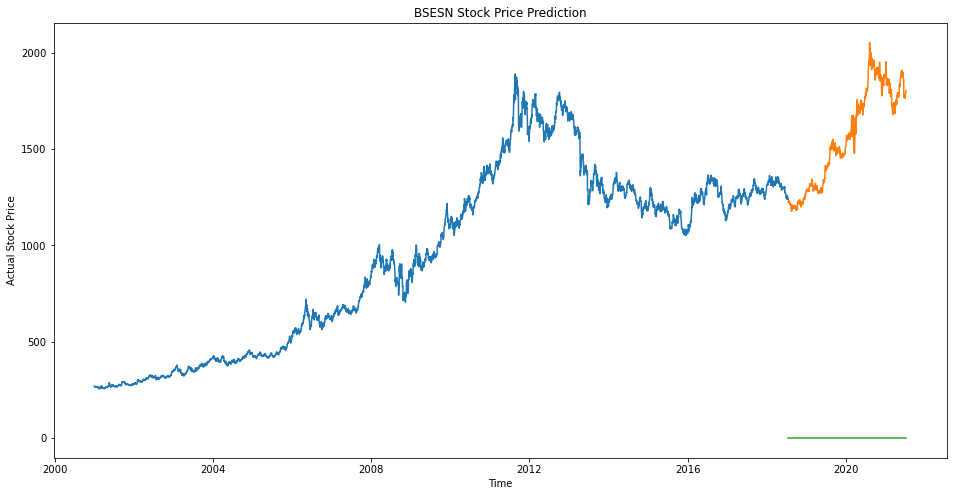

In [23]:
plt.figure(figsize=(16,8))
plt.plot(np.exp(train_log), label='Train')
plt.plot(np.exp(test_log), label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

C:\Users\charan varma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\charan varma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Plotting ARIMA model


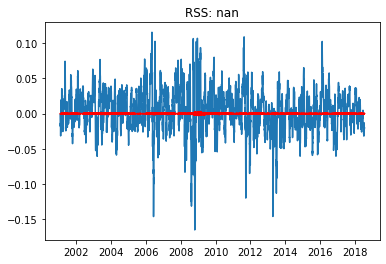

In [24]:
# AR+I+MA = ARIMA model
model = ARIMA(datasetLogDiffShifting, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting ARIMA model')

-------------------------------------------------------------------------------------------------------------------------------
===============================================================================================================================

# Using sentimental analysis of news headlines

In [25]:
stock_price

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,268.399994,268.399994,268.399994,268.399994,268.399994,0.0
2001-01-03,268.000000,268.000000,268.000000,268.000000,268.000000,1.0
2001-01-04,267.299988,267.299988,267.299988,267.299988,267.299988,1.0
2001-01-05,268.000000,268.000000,268.000000,268.000000,268.000000,0.0
2001-01-08,268.000000,268.000000,268.000000,268.000000,268.000000,0.0
...,...,...,...,...,...,...
2021-06-30,1761.099976,1770.800049,1759.199951,1770.800049,1770.800049,51.0
2021-07-01,1775.699951,1781.199951,1768.800049,1775.900024,1775.900024,44.0
2021-07-02,1778.699951,1787.900024,1778.300049,1782.599976,1782.599976,23.0


In [26]:
stock_headlines

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
...,...,...,...
3424062,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,removed,Govt extends deadline for use of FASTag till F...


In [27]:
stock_headlines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3399876 entries, 0 to 3424066
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 103.8+ MB


In [28]:
# date is int type change it to string and convert it to date format
#stringconversion
# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic
...,...,...,...
3424062,2020-12-31,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,2020-12-31,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,removed,Govt extends deadline for use of FASTag till F...


In [29]:
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()


In [30]:
#remove headline_category
stock_headlines = stock_headlines.drop(['headline_category'],axis =1)

In [31]:
stock_headlines

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3424062,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,Govt extends deadline for use of FASTag till F...


In [32]:
## we can see for single day many headlines have been released ,so group them and set indexes as length of values doesn't match 
# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

In [33]:
stock_headlines

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,"Powerless north India gropes in the dark,Think..."
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [34]:
# we scaled down to 7262 columns

In [35]:
#for plotting we need to set date as index in stock_headlines

In [36]:
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [37]:
stock_price

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,268.399994,268.399994,268.399994,268.399994,268.399994,0.0
2001-01-03,268.000000,268.000000,268.000000,268.000000,268.000000,1.0
2001-01-04,267.299988,267.299988,267.299988,267.299988,267.299988,1.0
2001-01-05,268.000000,268.000000,268.000000,268.000000,268.000000,0.0
2001-01-08,268.000000,268.000000,268.000000,268.000000,268.000000,0.0
...,...,...,...,...,...,...
2021-06-30,1761.099976,1770.800049,1759.199951,1770.800049,1770.800049,51.0
2021-07-01,1775.699951,1781.199951,1768.800049,1775.900024,1775.900024,44.0
2021-07-02,1778.699951,1787.900024,1778.300049,1782.599976,1782.599976,23.0


In [38]:
#REMOVE Adj Close as we don't use it 
stock_price = stock_price.drop(['Adj Close'],axis=1)

In [39]:
stock_price.head(3)

,Open,High,Low,Close,Volume
Date,,,,,
2001-01-02,268.399994,268.399994,268.399994,268.399994,0.0
2001-01-03,268.000000,268.000000,268.000000,268.000000,1.0
2001-01-04,267.299988,267.299988,267.299988,267.299988,1.0


In [40]:
stock_headlines.head(3)

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...


# data preparation for model

In [41]:
#Cleaning headlines by removing stopwords and stemming
c = []
ps = PorterStemmer()
for i in range(0,len(stock_headlines['headline_text'])):
    news = re.sub('[^a-zA-Z]',' ',stock_headlines['headline_text'][i])
    news = news.lower()
    news = news.split()
    #news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [42]:
len(c)

7262

In [43]:
pd.Series(c)

0       status quo will not be disturbed at ayodhya sa...
1       powerless north india gropes in the dark think...
2       the string that pulled stephen hawking to indi...
3       light combat craft takes india into club class...
4       light combat craft takes india into club class...
                              ...                        
7257    biginterview dhritiman chatterjee nobody dares...
7258    horoscope today december check astrological pr...
7259    man recovers charred remains of thief from his...
7260    numerology readings december predictions lucky...
7261    horoscope today december check astrological pr...
Length: 7262, dtype: object

In [44]:
#stock_headlines['headline_text'] = pd.Series(c)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [45]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [46]:
#Adding subjectivity and polarity columns
stock_headlines['Subjectivity'] = stock_headlines['headline_text'].apply(getSubjectivity)
stock_headlines['Polarity'] = stock_headlines['headline_text'].apply(getPolarity)
stock_headlines

,headline_text,Subjectivity,Polarity
publish_date,,,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.240909,0.148485
2001-01-03,"Powerless north India gropes in the dark,Think...",0.458333,0.108333
2001-01-04,The string that pulled Stephen Hawking to Indi...,0.512342,0.115404
2001-01-05,Light combat craft takes India into club class...,0.462652,0.257045
2001-01-06,Light combat craft takes India into club class...,0.464935,0.219481
...,...,...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.407395,0.044470
2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.417158,0.081137
2020-12-29,Man recovers charred remains of 'thief' from h...,0.412775,0.066816


In [47]:
stock_price

,Open,High,Low,Close,Volume
Date,,,,,
2001-01-02,268.399994,268.399994,268.399994,268.399994,0.0
2001-01-03,268.000000,268.000000,268.000000,268.000000,1.0
2001-01-04,267.299988,267.299988,267.299988,267.299988,1.0
2001-01-05,268.000000,268.000000,268.000000,268.000000,0.0
2001-01-08,268.000000,268.000000,268.000000,268.000000,0.0
...,...,...,...,...,...
2021-06-30,1761.099976,1770.800049,1759.199951,1770.800049,51.0
2021-07-01,1775.699951,1781.199951,1768.800049,1775.900024,44.0
2021-07-02,1778.699951,1787.900024,1778.300049,1782.599976,23.0


<AxesSubplot:>

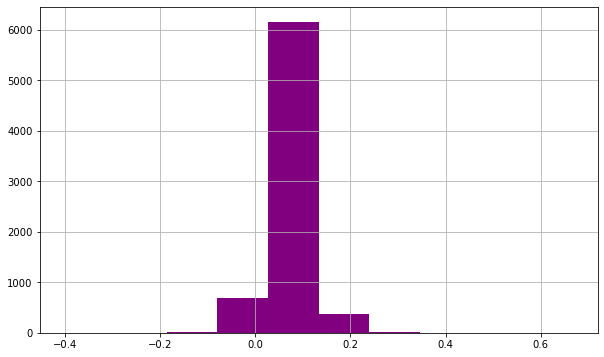

In [48]:
#lets plot the distribution of subjectivity and  polarity 
plt.figure(figsize = (10,6))
stock_headlines['Polarity'].hist(color = 'purple')


<AxesSubplot:>

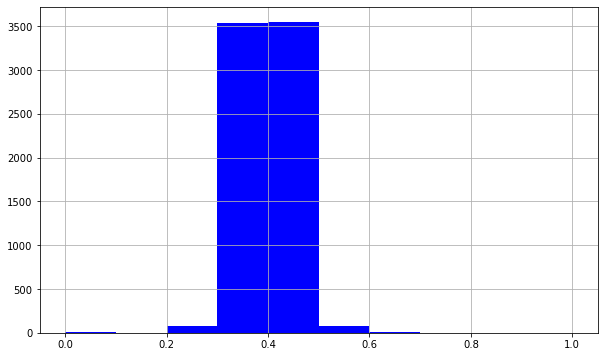

In [49]:

plt.figure(figsize = (10,6))
stock_headlines['Subjectivity'].hist(color = 'blue')

# They are almost normal
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

stock_headlines['Compound'] = [sia.polarity_scores(v)['compound'] for v in stock_headlines['headline_text']]
stock_headlines['Negative'] = [sia.polarity_scores(v)['neg'] for v in stock_headlines['headline_text']]
stock_headlines['Neutral'] = [sia.polarity_scores(v)['neu'] for v in stock_headlines['headline_text']]
stock_headlines['Positive'] = [sia.polarity_scores(v)['pos'] for v in stock_headlines['headline_text']]
stock_headlines

In [50]:

# concatenation of the datasets stock_price and stock_headlines
merged_stock = pd.concat([stock_price, stock_headlines], axis=1)
merged_stock.dropna(axis=0, inplace=True)

# displaying the combined stock_data
merged_stock

,Open,High,Low,Close,Volume,headline_text,Subjectivity,Polarity
2001-01-02,268.399994,268.399994,268.399994,268.399994,0.0,Status quo will not be disturbed at Ayodhya; s...,0.240909,0.148485
2001-01-03,268.000000,268.000000,268.000000,268.000000,1.0,"Powerless north India gropes in the dark,Think...",0.458333,0.108333
2001-01-04,267.299988,267.299988,267.299988,267.299988,1.0,The string that pulled Stephen Hawking to Indi...,0.512342,0.115404
2001-01-05,268.000000,268.000000,268.000000,268.000000,0.0,Light combat craft takes India into club class...,0.462652,0.257045
2001-01-08,268.000000,268.000000,268.000000,268.000000,0.0,"Sangh Parivar; Babri panel up the ante,Frontru...",0.316351,0.013447
...,...,...,...,...,...,...,...,...
2020-12-23,1867.000000,1878.800049,1864.500000,1874.699951,82.0,"Sawmill in Makarpura GIDC gutted; none hurt,Ci...",0.392756,0.081997
2020-12-28,1895.500000,1895.800049,1873.699951,1877.199951,75.0,Horoscope Today; 28 December 2020: Check astro...,0.417158,0.081137
2020-12-29,1881.300049,1881.300049,1879.699951,1879.699951,343.0,Man recovers charred remains of 'thief' from h...,0.412775,0.066816
2020-12-30,1879.900024,1895.800049,1877.300049,1891.000000,444.0,Numerology Readings 30 December 2020: Predicti...,0.433598,0.058847


In [51]:
#we will predict close stock price so clean Dataframe to our convinience
#stock = merged_stock[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
stock = merged_stock[['Open', 'Close',  'Volume', 'Polarity', 'Subjectivity']]
stock

,Open,Close,Volume,Polarity,Subjectivity
2001-01-02,268.399994,268.399994,0.0,0.148485,0.240909
2001-01-03,268.000000,268.000000,1.0,0.108333,0.458333
2001-01-04,267.299988,267.299988,1.0,0.115404,0.512342
2001-01-05,268.000000,268.000000,0.0,0.257045,0.462652
2001-01-08,268.000000,268.000000,0.0,0.013447,0.316351
...,...,...,...,...,...
2020-12-23,1867.000000,1874.699951,82.0,0.081997,0.392756
2020-12-28,1895.500000,1877.199951,75.0,0.081137,0.417158
2020-12-29,1881.300049,1879.699951,343.0,0.066816,0.412775
2020-12-30,1879.900024,1891.000000,444.0,0.058847,0.433598


In [52]:
#predicting closing prices
y=stock['Close']
X=stock.drop('Close', axis=1)

In [53]:
type(X)

pandas.core.frame.DataFrame

In [54]:
#first we will split data using train_test_split
#importing test train split
from sklearn.model_selection import train_test_split

#Train-Test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.15,shuffle=False)
X_test


,Open,Volume,Polarity,Subjectivity
2018-01-05,1320.300049,1.0,0.063854,0.374854
2018-01-08,1319.900024,41.0,0.087401,0.388622
2018-01-09,1309.599976,16.0,0.067696,0.390484
2018-01-10,1320.300049,70.0,0.052244,0.387770
2018-01-11,1317.099976,9.0,0.046267,0.341841
...,...,...,...,...
2020-12-23,1867.000000,82.0,0.081997,0.392756
2020-12-28,1895.500000,75.0,0.081137,0.417158
2020-12-29,1881.300049,343.0,0.066816,0.412775
2020-12-30,1879.900024,444.0,0.058847,0.433598


In [55]:
X_train

,Open,Volume,Polarity,Subjectivity
2001-01-02,268.399994,0.0,0.148485,0.240909
2001-01-03,268.000000,1.0,0.108333,0.458333
2001-01-04,267.299988,1.0,0.115404,0.512342
2001-01-05,268.000000,0.0,0.257045,0.462652
2001-01-08,268.000000,0.0,0.013447,0.316351
...,...,...,...,...
2017-12-28,1288.199951,245.0,0.047207,0.380737
2017-12-29,1294.199951,65.0,0.067322,0.425488
2018-01-02,1302.300049,68.0,0.056017,0.426495
2018-01-03,1320.000000,42.0,0.063918,0.395685


In [56]:
y_train

2001-01-02     268.399994
2001-01-03     268.000000
2001-01-04     267.299988
2001-01-05     268.000000
2001-01-08     268.000000
                 ...     
2017-12-28    1294.099976
2017-12-29    1306.300049
2018-01-02    1313.699951
2018-01-03    1316.199951
2018-01-04    1319.400024
Name: Close, Length: 4214, dtype: float64

In [57]:
y_test

2018-01-05    1320.300049
2018-01-08    1318.599976
2018-01-09    1311.699951
2018-01-10    1317.400024
2018-01-11    1320.599976
                 ...     
2020-12-23    1874.699951
2020-12-28    1877.199951
2020-12-29    1879.699951
2020-12-30    1891.000000
2020-12-31    1893.099976
Name: Close, Length: 744, dtype: float64

#this is our final dataframe here after just regression models
#our dataset has big integers, so scale down them using minmaxscaler

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [58]:
#define models

In [59]:
def check(pred):
    a=y_test.to_frame()
    b = pd.DataFrame(pred,columns=["Predicted value"],index=y_test.index)
    final = pd.concat([a,b], axis=1)
    print('MSE',np.sqrt(mean_squared_error(pred,y_test)))
    print('acc_rf', acc_rf)
    # plotting
    #plt.style.use('dark_background')
    # reset rcParams
    #plt.rcParams.update(IPython_default);
    plt.figure(figsize=(16,10))
    plt.grid(color='w', linestyle='solid')
    plt.plot(a, label="closing_price",color='red')
    plt.plot(b, label="closing_pice_hat")
    plt.legend(loc ='best')
    plt.show()
    return final

    
    

## random forest regressor

In [60]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
acc_rf =rf.score(X_test,y_test)
rf_pred =rf.predict(X_test)


MSE 35.91767470502974
acc_rf 0.9772854167752709


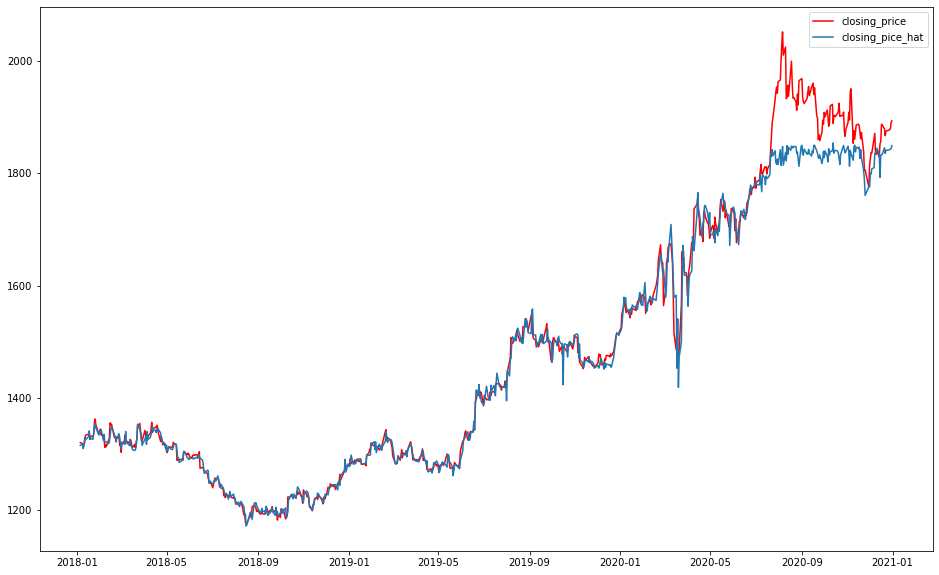

,Close,Predicted value
2018-01-05,1320.300049,1315.232993
2018-01-08,1318.599976,1317.903978
2018-01-09,1311.699951,1309.639004
2018-01-10,1317.400024,1318.262001
2018-01-11,1320.599976,1329.148008
...,...,...
2020-12-23,1874.699951,1840.624011
2020-12-28,1877.199951,1841.756023
2020-12-29,1879.699951,1842.995017
2020-12-30,1891.000000,1844.111981


In [61]:
check(rf_pred)

## XGB regressor


In [62]:
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error
xgb = XGBRegressor(n_estimators = 20000, n_jobs = -1, learning_rate = 0.10, random_state = 0, max_depth = 8, reg_lambda = 0.5)
xgb.fit(X_train, y_train, early_stopping_rounds = 200, eval_set = [(X_test,y_test)], eval_metric = 'rmse', verbose =0)
cv_pred = xgb.predict(X_test)
print(xgb.score(X_test,y_test))

0.9705122352323606


MSE 40.92387535645296
acc_rf 0.9772854167752709


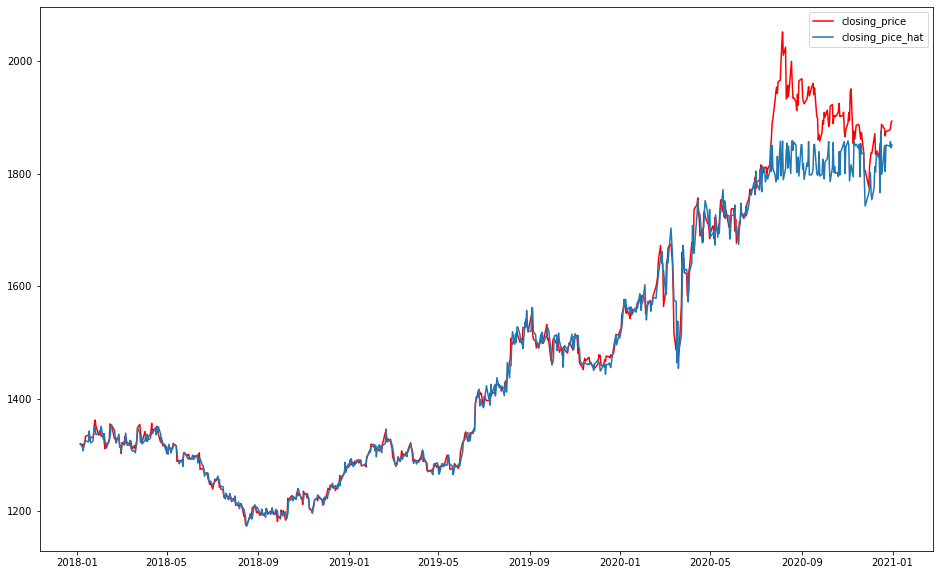

,Close,Predicted value
2018-01-05,1320.300049,1319.910400
2018-01-08,1318.599976,1313.856812
2018-01-09,1311.699951,1307.733276
2018-01-10,1317.400024,1320.525635
2018-01-11,1320.599976,1323.124756
...,...,...
2020-12-23,1874.699951,1850.722290
2020-12-28,1877.199951,1848.549683
2020-12-29,1879.699951,1856.847046
2020-12-30,1891.000000,1845.492432


In [63]:
check(cv_pred)

## Linear regression

In [64]:
#LINEAR REGRESSION
from sklearn.linear_model import LinearRegression
LinearRegression_model= LinearRegression()
LinearRegression_model.fit(X_train,y_train)
LinearRegression_model.score(X_test,y_test)


0.9964492179429435

MSE 14.20096427422867
acc_rf 0.9772854167752709


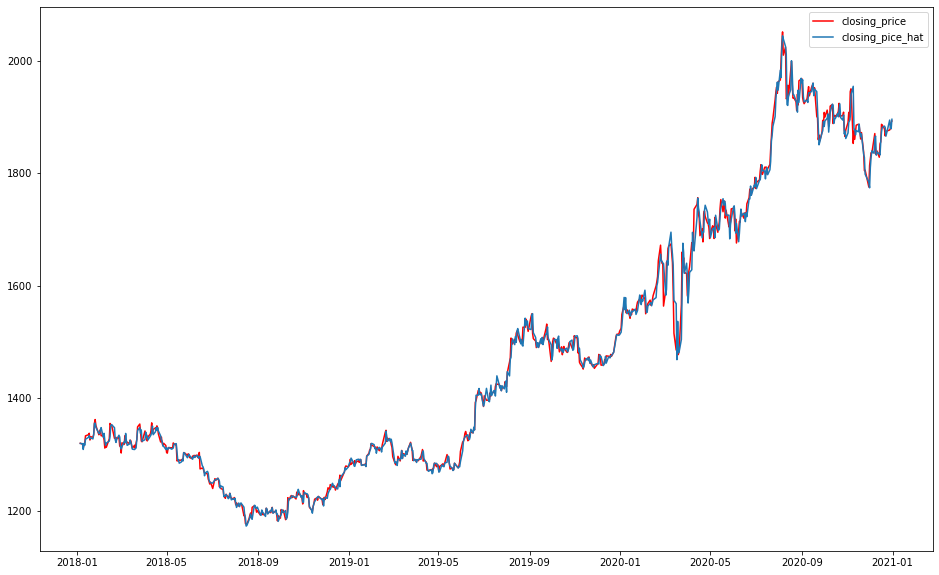

,Close,Predicted value
2018-01-05,1320.300049,1319.862648
2018-01-08,1318.599976,1319.474620
2018-01-09,1311.699951,1309.211348
2018-01-10,1317.400024,1319.914800
2018-01-11,1320.599976,1316.587647
...,...,...
2020-12-23,1874.699951,1866.236098
2020-12-28,1877.199951,1894.791486
2020-12-29,1879.699951,1880.602620
2020-12-30,1891.000000,1879.274464


In [65]:
lr_pred = LinearRegression_model.predict(X_test)
check(lr_pred)

In [82]:
#predicted plot is pretty much matching with test plot